## Dataset Overview
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma 

## Importing libraries

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score


## Reading the Data

In [5]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


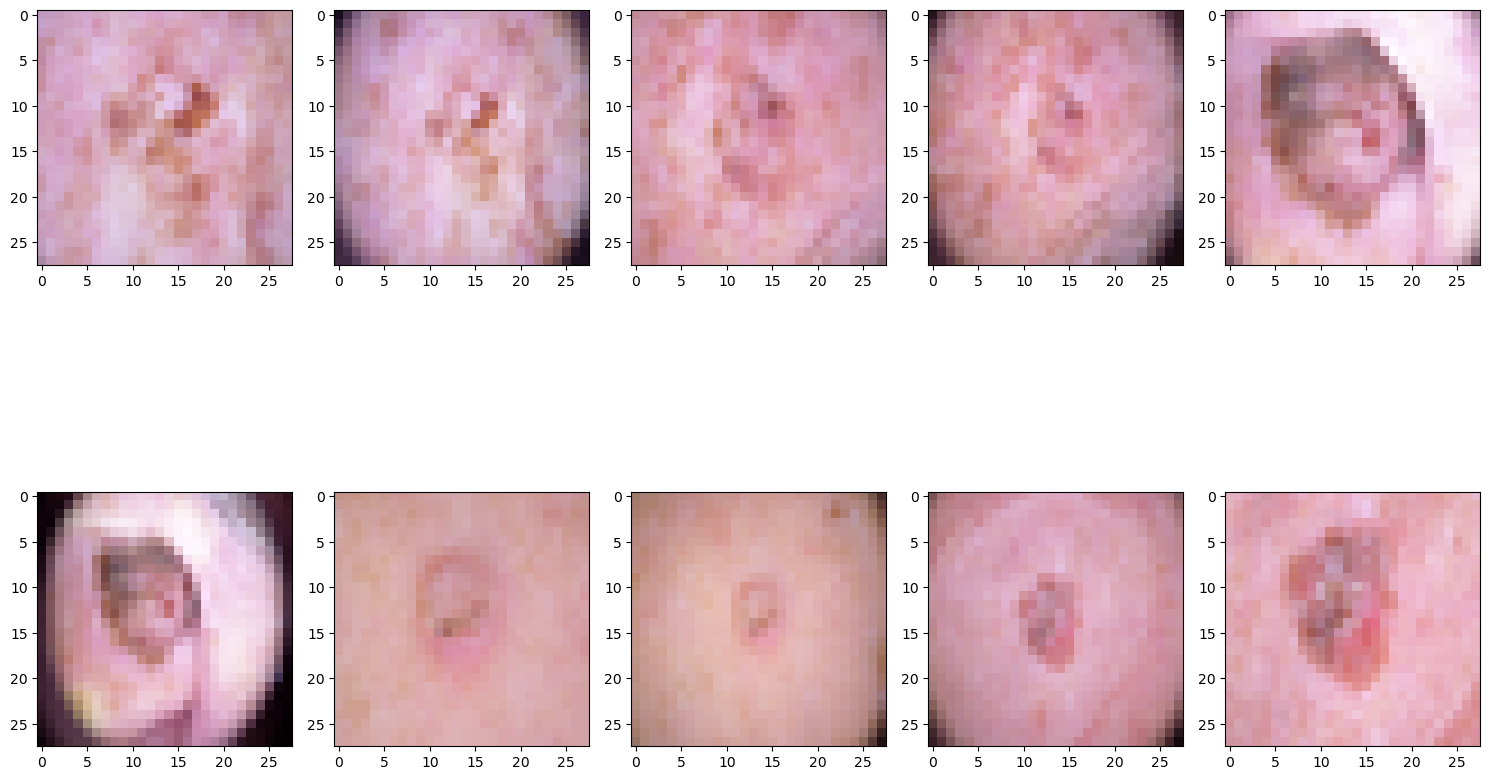

In [6]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
y1 = data['label']
x1 = data.drop(columns = ['label'])
x1= np.array(x1).reshape(-1,28,28,3)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x1[k].reshape(28,28,3))
#         ax[i, j].set_title(f"Image {Y_train[4]}")
        k = k + 1
    plt.tight_layout()

## Data Preprocessing
## Data Cleaning

In [7]:
data['label'].unique()
y = data['label']
x = data.drop(columns = ['label'])
data.isnull().sum().sum() #no null values present

0

In [8]:
meta_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
meta_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [10]:
data.isnull().sum().sum() #no null values present
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency Distribution of Classes')

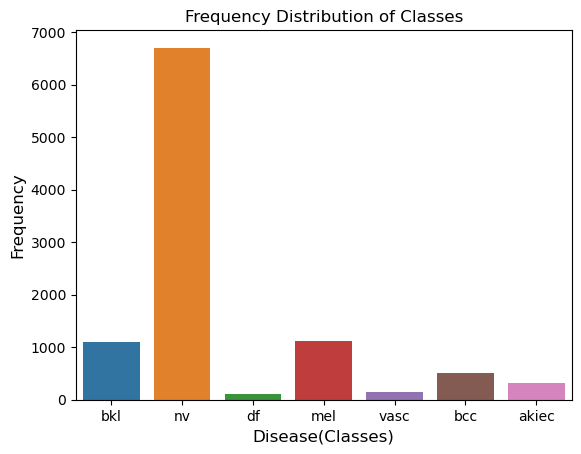

In [11]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease(Classes)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes')

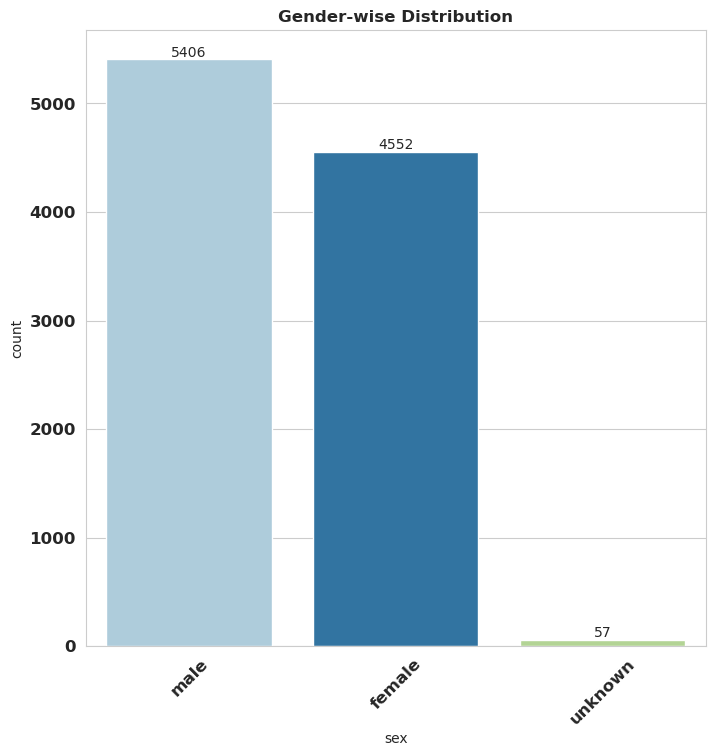

In [12]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(8,8))

ax = sns.countplot(x='sex',data=meta_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution',fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.show()

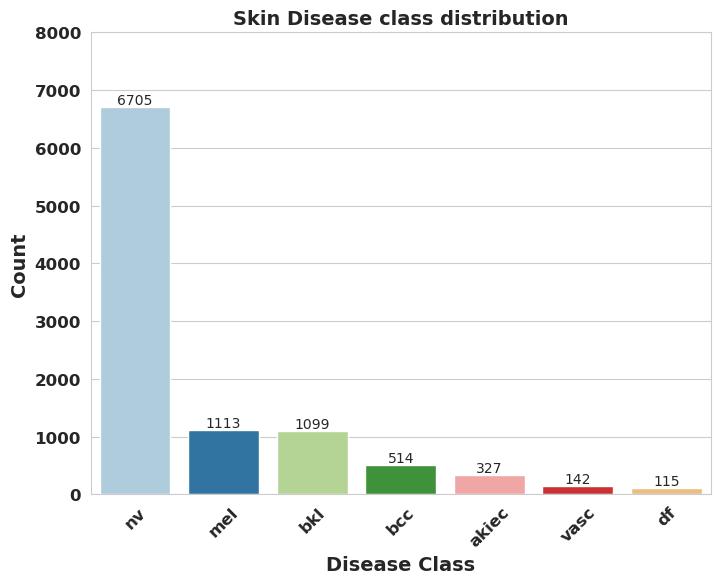

In [13]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='dx',data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Skin Disease class distribution',fontweight='bold',fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)
plt.show()

In [14]:
classes = {2:'bkl', 4:'nv', 3:'df', 6:'mel', 5:'vasc', 1:'bcc', 0:'akiec'}

classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[2, 4, 3, 6, 5, 1, 0]


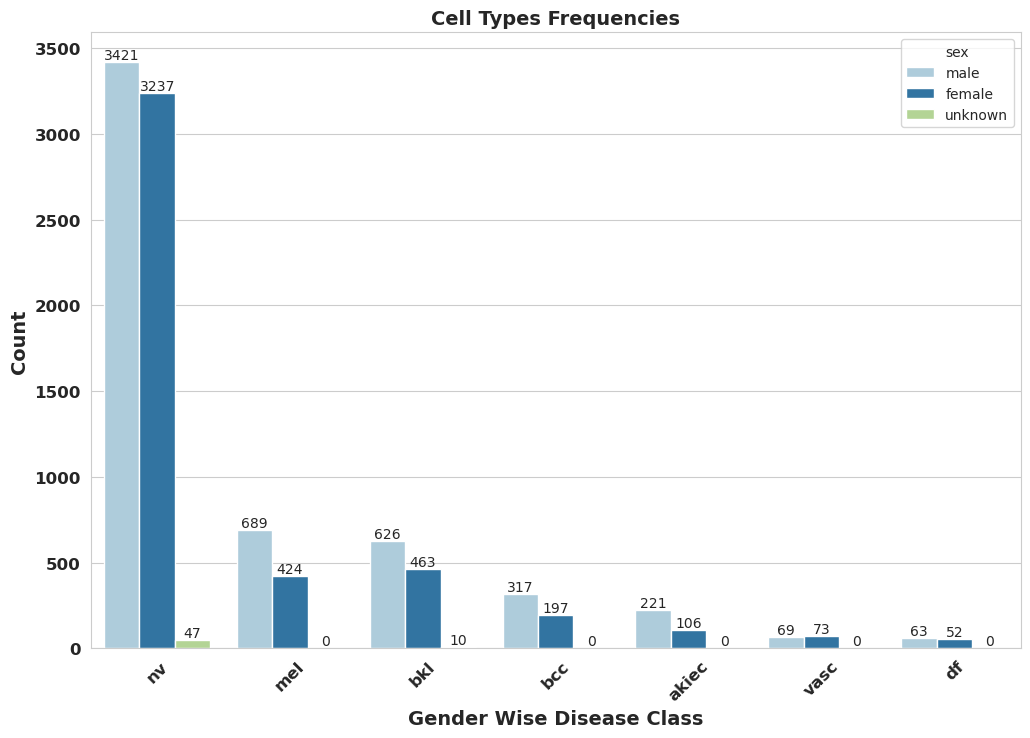

In [15]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Gender Wise Disease Class", fontweight='bold', fontsize=14)
plt.show()

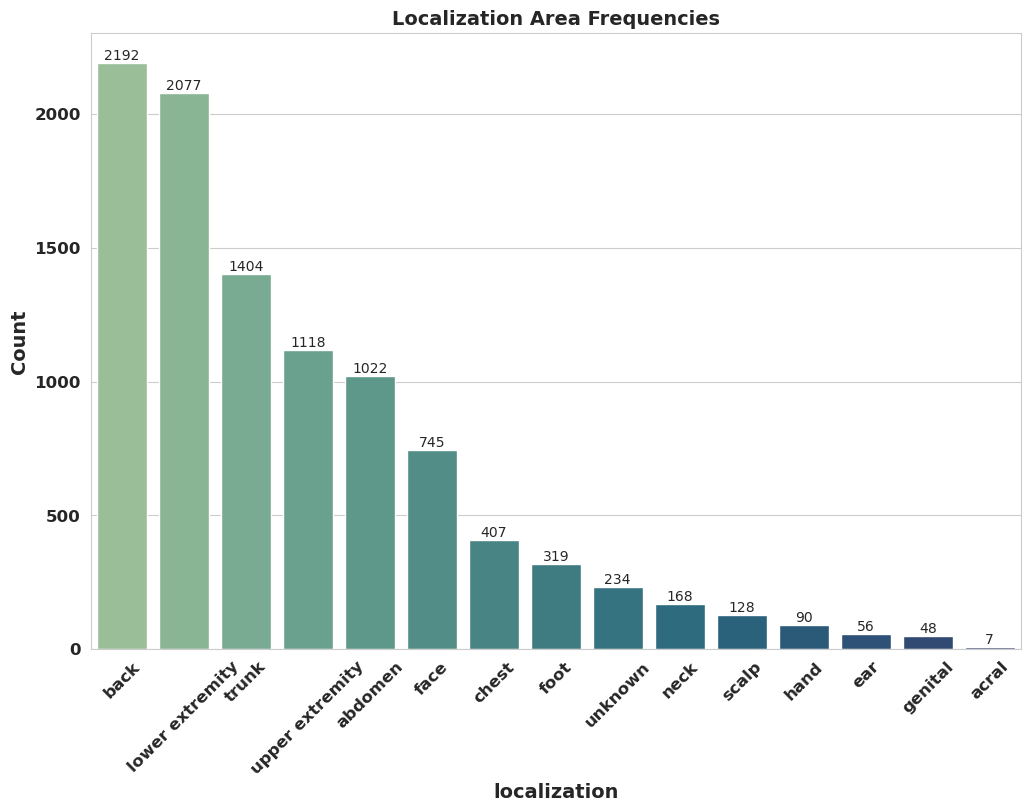

In [16]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=meta_data, order = meta_data['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("localization", fontweight='bold', fontsize=14)
plt.show()

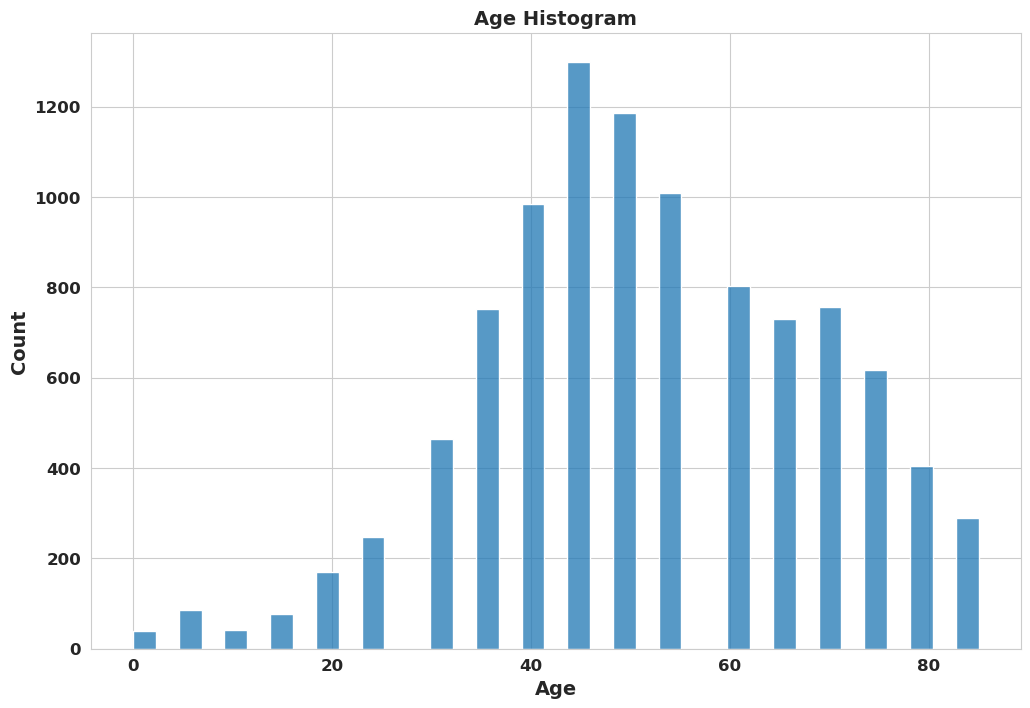

In [18]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age')
plt.title('Age Histogram',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

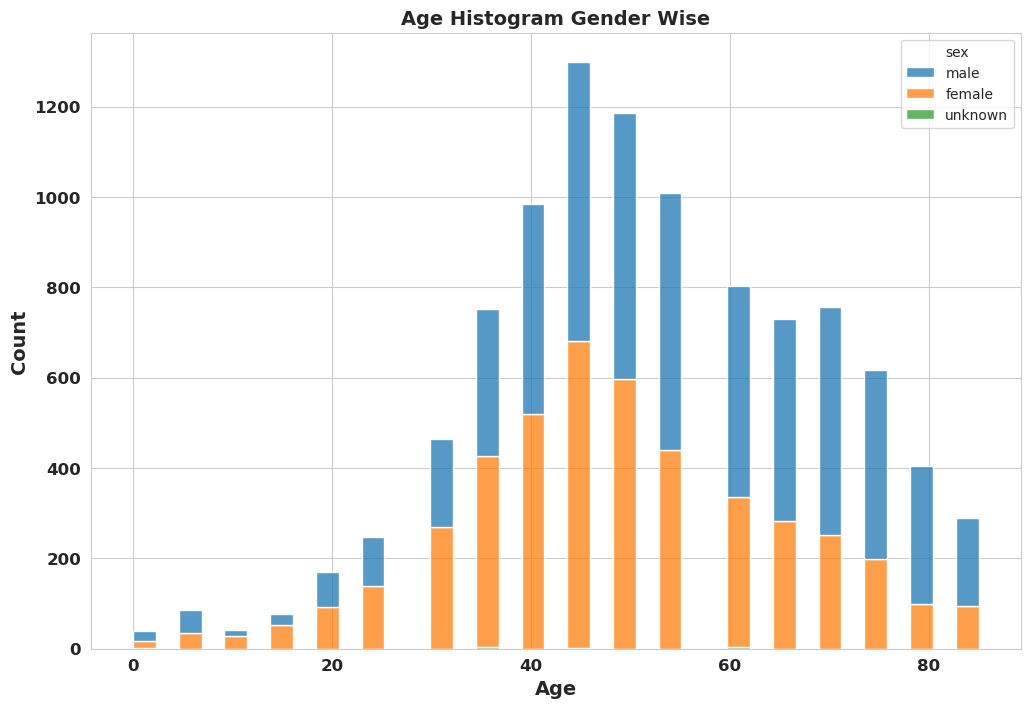

In [19]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

In [20]:
# Splitting Data
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)
print(X_train.shape,Y_train.shape)
print(X_test.shape , Y_test.shape)

(8012, 2352) (8012,)
(2003, 2352) (2003,)


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


# # Create an ImageDataGenerator with desired augmentation options
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True
# )
# X_train= np.array(X_train).reshape(-1,28,28,3)

# # Fit the ImageDataGenerator on the training data
# datagen.fit(X_train)

# # Generate augmented data
# augmented_data = datagen.flow(X_train, Y_train, batch_size=len(X_train), shuffle=False)

# # Extract augmented samples and labels
# augmented_samples, augmented_labels = next(augmented_data)

# # Concatenate original and augmented data
# balanced_x = np.concatenate((X_train, augmented_samples))
# balanced_y = np.concatenate((Y_train, augmented_labels))

# print(balanced_x.shape, balanced_y.shape)

In [19]:
# X_train=balanced_x
# Y_train=balanced_y

In [18]:
# print(X_train.shape,Y_train.shape)
# # To overcome class imbalace
# oversample = RandomOverSampler()
# balanced_x,balanced_y  = oversample.fit_resample(X_train,Y_train)
# print(balanced_x.shape,balanced_y.shape)
# X_train=balanced_x
# Y_train=balanced_y

In [19]:
# import numpy as np
# from imblearn.over_sampling import ADASYN

# # Assuming you have your feature data 'X' and corresponding labels 'y'


# # Instantiate the ADASYN oversampler
# adasyn = ADASYN(random_state=42)

# # Resample the data using ADASYN
# balanced_x, balanced_y = adasyn.fit_resample(X_train, Y_train)

# # Check the class distribution after resampling
# unique, counts = np.unique(balanced_y, return_counts=True)
# print(dict(zip(unique, counts)))
# X_train=balanced_x
# Y_train=balanced_y

{0: 5320, 1: 5321, 2: 5559, 3: 5358, 4: 5378, 5: 5359, 6: 5449}


In [21]:
# # reshaping the data so that it can be taken by convolution neural network(without disturbing the no. of samples)
X_train= np.array(X_train).reshape(-1,28,28,3)
print('Shape of X :',X_train.shape)
print('Shape of y :',Y_train.shape)

Shape of X : (8012, 28, 28, 3)
Shape of y : (8012,)


In [22]:
X_test= np.array(X_test).reshape(-1,28,28,3)


In [23]:
print(Y_train)

1074    2
3588    4
8385    4
2205    6
2441    5
       ..
2895    1
7813    4
905     2
5192    4
235     2
Name: label, Length: 8012, dtype: int64


In [24]:
classes = {4:'melanocytic nevi',
6: 'melanoma',
2:'benign keratosis-like lesions',
1:'basal cell carcinoma',
5:'pyogenic granulomas and hemorrhage',
0:'Actinic keratoses and intraepithelial carcinomae',
3:'dermatofibroma'}


In [25]:
Y_train[:10]

1074    2
3588    4
8385    4
2205    6
2441    5
3759    4
115     2
7822    4
8258    4
6214    4
Name: label, dtype: int64

In [26]:
l_train = np.array(Y_train)
l_train[1]

4

In [27]:
from PIL import Image

# Reshape training images
resized_X_train = np.zeros((X_train.shape[0], 32, 32, 3))
for i in range(X_train.shape[0]):
    img = Image.fromarray(X_train[i].astype('uint8'))
    img = img.resize((32, 32))
    resized_X_train[i] = np.array(img)

# Reshape test images
resized_X_test = np.zeros((X_test.shape[0], 32, 32, 3))
for i in range(X_test.shape[0]):
    img = Image.fromarray(X_test[i].astype('uint8'))
    img = img.resize((32, 32))
    resized_X_test[i] = np.array(img)

# Verify the shape of the resized images
print("Resized X_train shape:", resized_X_train.shape)
print("Resized X_test shape:", resized_X_test.shape)


Resized X_train shape: (8012, 32, 32, 3)
Resized X_test shape: (2003, 32, 32, 3)


In [28]:
import keras
train_labels_one_hot = keras.utils.to_categorical(Y_train)
test_labels_one_hot = keras.utils.to_categorical(Y_test)

In [101]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Modify the architecture for the new input size
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Create the modified model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(resized_X_train, train_labels_one_hot, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(resized_X_test, test_labels_one_hot)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Modify the architecture for the new input size
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Create the modified model
model = Model(inputs=base_model.input, outputs=predictions)




58889256/58889256 [==============================] - 4s 0us/step


In [28]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(resized_X_train, train_labels_one_hot, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(resized_X_test, test_labels_one_hot)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/10
401/401 [==============================] - 12s 12ms/step - loss: 2.6931 - accuracy: 0.6440 - val_loss: 1.4447 - val_accuracy: 0.6733
Epoch 2/10
401/401 [==============================] - 3s 9ms/step - loss: 1.0557 - accuracy: 0.7098 - val_loss: 0.9923 - val_accuracy: 0.7307
Epoch 3/10
401/401 [==============================] - 4s 9ms/step - loss: 0.7528 - accuracy: 0.7501 - val_loss: 0.8599 - val_accuracy: 0.7298
Epoch 4/10
401/401 [==============================] - 4s 9ms/step - loss: 0.6181 - accuracy: 0.7849 - val_loss: 0.9012 - val_accuracy: 0.7388
Epoch 5/10
401/401 [==============================] - 4s 9ms/step - loss: 0.5503 - accuracy: 0.8006 - val_loss: 0.7974 - val_accuracy: 0.7607
Epoch 6/10
401/401 [==============================] - 4s 9ms/step - loss: 0.5033 - accuracy: 0.8174 - val_loss: 0.8076 - val_accuracy: 0.7557
Epoch 7/10
401/401 [==============================] - 4s 10ms/step - loss: 0.4612 - accuracy: 0.8313 - val_loss: 0.8007 - val_accuracy: 0.7544
Epo

In [164]:
# model_CNN = Sequential()
# model_CNN.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
# model_CNN.add(BatchNormalization())


# model_CNN.add(MaxPool2D(pool_size = (2,2)))


# model_CNN.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model_CNN.add(BatchNormalization())

# model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
# model_CNN.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
# model_CNN.add(BatchNormalization())

# model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

# model_CNN.add(Flatten())


# model_CNN.add(Dense(64, activation = 'relu'))
# model_CNN.add(BatchNormalization())


# model_CNN.add(Dense(32))
# model_CNN.add(Activation(activation='relu'))
# model_CNN.add(BatchNormalization())

# model_CNN.add(Dense(16))
# model_CNN.add(Activation(activation='relu'))
# model_CNN.add(BatchNormalization())

# model_CNN.add(Dense(7))
# model_CNN.add(Activation(activation='softmax'))

# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# model_CNN.compile(loss = 'sparse_categorical_crossentropy',
#                  optimizer = optimizer,
#                   metrics = ['accuracy'])
# print(model_CNN.summary())

In [165]:
# print('Shape of X :',X_train.shape)
# print('Shape of y :',Y_train.shape)

In [166]:
# history = model_CNN.fit(X_train,
#                     Y_train,
#                     validation_split=0.2,
#                     batch_size = 64,
#                     epochs = 30
#                     )

In [167]:
# results = model_CNN.evaluate(X_test , Y_test, verbose=0)

# print("CNN Model Test Results")
# print("        Test Loss: {:.5f}".format(results[0]))
# print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

In [29]:
from PIL import Image
import numpy as np
import os

def add_translation_noise_dataset(X_test, Y_test, max_translation, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    noisy_image_dataset = []

    for i, (image, label) in enumerate(zip(X_test, Y_test)):
        width, height, channels = image.shape

        # Convert the NumPy array to a PIL Image object
        pil_image = Image.fromarray(image.astype('uint8'))

        # Generate random translation values
        translation_x = np.random.randint(-max_translation, max_translation + 1)
        translation_y = np.random.randint(-max_translation, max_translation + 1)

        # Create the translation matrix
        translation_matrix = (1, 0, translation_x, 0, 1, translation_y)

        # Apply the translation to the image
        translated_image = pil_image.transform((width, height), Image.AFFINE, translation_matrix)

        noisy_image_array = np.array(translated_image)
        noisy_image_dataset.append(noisy_image_array)

        # Save the noisy image with its label
        image_name = f'image_{i}_label_{label}.jpg'
        image_path = os.path.join(output_dir, image_name)
        translated_image.save(image_path)
    noisy_image_dataset = np.array(noisy_image_dataset)

    # Reshape the numpy array
    noisy_image_dataset = noisy_image_dataset.reshape(-1, 32, 32, 3)
    return noisy_image_dataset


In [30]:
def scaling_and_crop_noise_dataset(X_test, Y_test, min_scale, max_scale, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    scaled_and_cropped_noise_dataset = []
    
    for i, (image, label) in enumerate(zip(X_test, Y_test)):
        width, height, channels = image.shape

        # Generate a random scaling factor
        scaling_factor = np.random.uniform(min_scale, max_scale)

        # Calculate the new dimensions
        new_width = int(width * scaling_factor)
        new_height = int(height * scaling_factor)

        # Resize the image using the new dimensions
        scaled_image = Image.fromarray(image.astype('uint8')).resize((new_width, new_height))
        
        # Crop the scaled image to a size of 28x28x3
        left = (new_width - 32) // 2
        top = (new_height - 32) // 2
        right = left + 32
        bottom = top + 32
        cropped_image = scaled_image.crop((left, top, right, bottom))

        scaled_and_cropped_noise_dataset.append(np.array(cropped_image))

        # Save the noisy image with its label
        image_name = f'image_{i}_label_{label}.jpg'
        image_path = os.path.join(output_dir, image_name)
        cropped_image.save(image_path)
    
    scaled_and_cropped_noise_dataset = np.array(scaled_and_cropped_noise_dataset)

    # Reshape the numpy array
    scaled_and_cropped_noise_dataset = scaled_and_cropped_noise_dataset.reshape(-1, 32, 32, 3)
    return scaled_and_cropped_noise_dataset

In [31]:
from PIL import Image
import numpy as np
import os

def add_rotation_noise(image, max_angle):
    # Generate a random rotation angle
    angle = np.random.uniform(-max_angle, max_angle)
    
    # Apply the rotation to the image
    rotated_image = image.rotate(angle)
    
    return rotated_image

def add_rotation_noise_dataset(X_test, Y_test, max_angle, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    noisy_image_dataset = []
    
    for i, (image, label) in enumerate(zip(X_test, Y_test)):
        pil_image = Image.fromarray(image.astype('uint8'))
        noisy_image = add_rotation_noise(pil_image, max_angle)
        noisy_image_array = np.array(noisy_image)
        noisy_image_dataset.append(noisy_image_array)
        
        # Save the noisy image with its label
        image_name = f'image_{i}_label_{label}.jpg'
        image_path = os.path.join(output_dir, image_name)
        noisy_image.save(image_path)
    
    noisy_image_dataset = np.array(noisy_image_dataset)

    # Reshape the numpy array
    noisy_image_dataset = noisy_image_dataset.reshape(-1, 32, 32, 3)

    return noisy_image_dataset


In [32]:


min_scale=0.5
max_scale=5
scaled_noise_dataset = scaling_and_crop_noise_dataset(resized_X_test, test_labels_one_hot, min_scale, max_scale, '/kaggle/working/Scalling_and_cropping_Noise_test_Data')

max_translation=5
translated_noise_dataset = add_translation_noise_dataset(resized_X_test, test_labels_one_hot,max_translation, '/kaggle/working/Translation_Noise_test_Data')


max_angle=360
rotation_noise_dataset = add_rotation_noise_dataset(resized_X_test, test_labels_one_hot, max_angle, '/kaggle/working/Rotation_Noise_test_Data')

ALL_test_datasets=[resized_X_test,translated_noise_dataset,scaled_noise_dataset,rotation_noise_dataset]

In [33]:
test_datasets=['Orignal Test Data','Translated Noise Test Data','Scalled Noise Test Data','Rotation Noise Test Data']

In [34]:
scaled_noise_dataset.shape

(2003, 32, 32, 3)

In [35]:
def evaluate(X_test_noise,Y_test):
    
    results = model.evaluate(X_test_noise , Y_test, verbose=0)
    return results

In [36]:
for i in range(len(ALL_test_datasets)):
    res=evaluate(ALL_test_datasets[i],test_labels_one_hot)
    print(f"Test on {test_datasets[i]}")
    print("        Test Loss: {:.5f}".format(res[0]))
    print("    Test Accuracy: {:.2f}%".format(res[1] * 100))



Test on Orignal Test Data
        Test Loss: 1.17286
    Test Accuracy: 70.54%
Test on Translated Noise Test Data
        Test Loss: 3.36008
    Test Accuracy: 64.95%
Test on Scalled Noise Test Data
        Test Loss: 2.28656
    Test Accuracy: 61.66%
Test on Rotation Noise Test Data
        Test Loss: 5.70977
    Test Accuracy: 61.86%


In [37]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(test_labels_one_hot)
y_pred_CNN = model.predict(resized_X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

63/63 [==============================] - 0s 5ms/step
Predicting First Ten Rows:
Y Actual Values : [array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 1., 0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)]
Y Predicted Values : [4, 4, 4, 4, 2, 4, 4, 4, 4, 1]


In [38]:
# Layers definitions
from keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.engine.input_layer.InputLayer object at 0x7fdf5340dd20>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf5368f760>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf532655d0>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fdf53374c40>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf532db7f0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf5368dc00>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fdf45cc7550>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf45cc63b0>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf53bb7a60>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf45cc7970>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fdf45cc7670>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf533a31c0>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf45cc6110>
13 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdf453f1450>


In [39]:
model.layers[-2]

In [40]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


## Separating Features Layers from the CNN Model

In [41]:
import tensorflow as tf
# feature_extractor = tf.keras.Model(inputs=model_CNN.input, 
#                                     outputs=model_CNN.get_layer(-2).output)
# output_layers_model =tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.output)
# cnn_layer_output = model_CNN.layers[-2].output
# cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=cnn_layer_output)
cnn_model_features = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)


## Extracting Features from CNN Model

In [60]:
# Extract features from input data using the CNN model
#ALL_test_datasets=[X_test,X_text_noise_01,X_text_noise_02,translated_noise_dataset,scaled_noise_dataset,rotation_noise_dataset]
X_train_cnn = cnn_model_features.predict(resized_X_train)
X_test_cnn = cnn_model_features.predict(scaled_noise_dataset)

63/63 [==============================] - 0s 4ms/step


## Integrating CNN with SVM Classifier using Grid Search for Best Perameters

In [61]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf=SVC(kernel='rbf',C=100,gamma=0.001)
kf=KFold(n_splits=5)
scores_SVM = cross_val_score(clf, X_train_cnn, Y_train, cv=kf)
print(scores_SVM)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_SVM.mean(), scores_SVM.std()))
clf.fit(X_train_cnn,Y_train)
# Evaluate the combined CNN-SVM model on a test dataset
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
y_testSVM = clf.predict(X_test_cnn)

[0.6698908  0.6698908  0.67457098 0.66614665 0.67571785]
0.67 accuracy with a standard deviation of 0.00
SVM Accuracy: 66.25062406390414


In [62]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)


SVM Accuracy: 66.25062406390414


## Integrating CNN with Random Forest Classifier using Grid Search for Best Perameters

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rgclf = RandomForestClassifier(max_depth=3,
               max_features=1,
               min_samples_split=3,
               bootstrap=False,
               criterion=  "entropy",
               n_estimators=20)
kf=KFold(n_splits=5)
scores_RF = cross_val_score(rgclf, X_train_cnn, Y_train, cv=kf)
print(scores_RF)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_RF.mean(), scores_RF.std()))
rgclf.fit(X_train_cnn, Y_train)
RFC_accuracy = rgclf.score(X_test_cnn, Y_test)
print('Random Forest Classifier Accuracy:', RFC_accuracy*100)
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

[0.6698908  0.6698908  0.67457098 0.66614665 0.67571785]
0.67 accuracy with a standard deviation of 0.00
Random Forest Classifier Accuracy: 66.25062406390414
Accuracy: 66.25062406390414


In [64]:
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))


Accuracy: 66.25062406390414


In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# parameters = {"n_neighbors": [1],
#               "weights": ['uniform', 'distance'],
#               "metric": ['minkowski','euclidean','manhattan'],
#               "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kgclf = KNeighborsClassifier(n_neighbors=1,
              weights='distance',
              metric='euclidean',
              algorithm= 'auto')
kf=KFold(n_splits=5)
scores_KNN = cross_val_score(kgclf, X_train_cnn, Y_train, cv=kf)
print(scores_KNN)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_KNN.mean(), scores_KNN.std()))
kgclf.fit(X_train_cnn, Y_train)
KNN_accuracy = kgclf.score(X_test_cnn, Y_test)
print('KNN Classifier Accuracy:', KNN_accuracy*100)



[0.8299532  0.82402496 0.82340094 0.80780031 0.82771536]
0.82 accuracy with a standard deviation of 0.01
KNN Classifier Accuracy: 48.477284073889166


#### Integrating CNN with Logistic Regression Classifier using Grid Search for Best Perameters

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# Create a logistic regression object
grid_search_LR = LogisticRegression(C=100,
              penalty='l2')
kf=KFold(n_splits=5)
scores_LR = cross_val_score(grid_search_LR, X_train_cnn, Y_train, cv=kf)
print(scores_LR)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_LR.mean(), scores_LR.std()))
# Perform grid search with 5-fold cross-validation
grid_search_LR.fit(X_train_cnn, Y_train)

# Print the best hyperparameters and the corresponding accuracy score
y_test_LR = grid_search_LR.predict(X_test_cnn)

print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_LR)*100))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.7351014  0.73073323 0.73541342 0.72542902 0.73689139]
0.73 accuracy with a standard deviation of 0.00
Accuracy: 64.20369445831253


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)

KNN_accuracy = kgclf.score(X_test_cnn, Y_test)
print('KNN Classifier Accuracy:', KNN_accuracy*100)

RFC_accuracy = rgclf.score(X_test_cnn, Y_test)
print('Random Forest Classifier Accuracy:', RFC_accuracy*100)

LR_accuracy = grid_search_LR.score(X_test_cnn, Y_test)
print('Logistic Regression:', LR_accuracy*100)

SVM Accuracy: 66.25062406390414
KNN Classifier Accuracy: 48.477284073889166
Random Forest Classifier Accuracy: 66.25062406390414
Logistic Regression: 64.20369445831253



### 